# Linear Regression - OLS Polynomial Regression & Stochastic Gradient Descent 


There are four tasks:
- Perform Polynomial Regression using sklearn's OLS method
- Plot degree vs. error to choose optimal degree for a fixed set datasize
- Plot learning curves to investigate how the size of training data influeces the model performance for various polynomial models
- Using the optimal degree obtained from OLS Polynomial Regression, perform Linear (Polynomial) Regression using sklearn's SGDRegressor

You will use the **Red wine** quality dataset from the following link.

## Dataset

URL: https://archive.ics.uci.edu/ml/datasets/wine+quality

The dataset is related to the **Red** variants of the Portuguese "Vinho Verde" wine. It provides the physicochemical (inputs) and sensory (the output) variables are available.

The dataset consists of characteristics of white wine (e.g., alcohol content, density, amount of citric acid, pH, etc) with target variable "quality" representing rating of wine.


Given the characteristics of a new, unlabeled wine, the regression task is to predict its "quality".

Input variables (based on physicochemical tests):
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Output variable (based on sensory data): 
- quality 


In [41]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor

## Load Data

First load the data and explore the feature names, target names, etc.

In [25]:
# Load data
df = pd.read_csv('/Users/ryguy/Documents/UNL/Classes/Practical Machine Learning/winequality-red.csv', header=0)
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Exploratory Data Analysis

Perform EDA and determine the following:
- Are the input variables collinear?
- Do you need to drop any input variable column? 

Drop the redundant columns if need be. However, if dropping a column doesn't achieve the best accuracy, then don't drop it.

In [26]:
# Find feature correlation to target column
df.corr()['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

In [27]:
# check for any NaN values in dataset
df.isna().values.any()

False

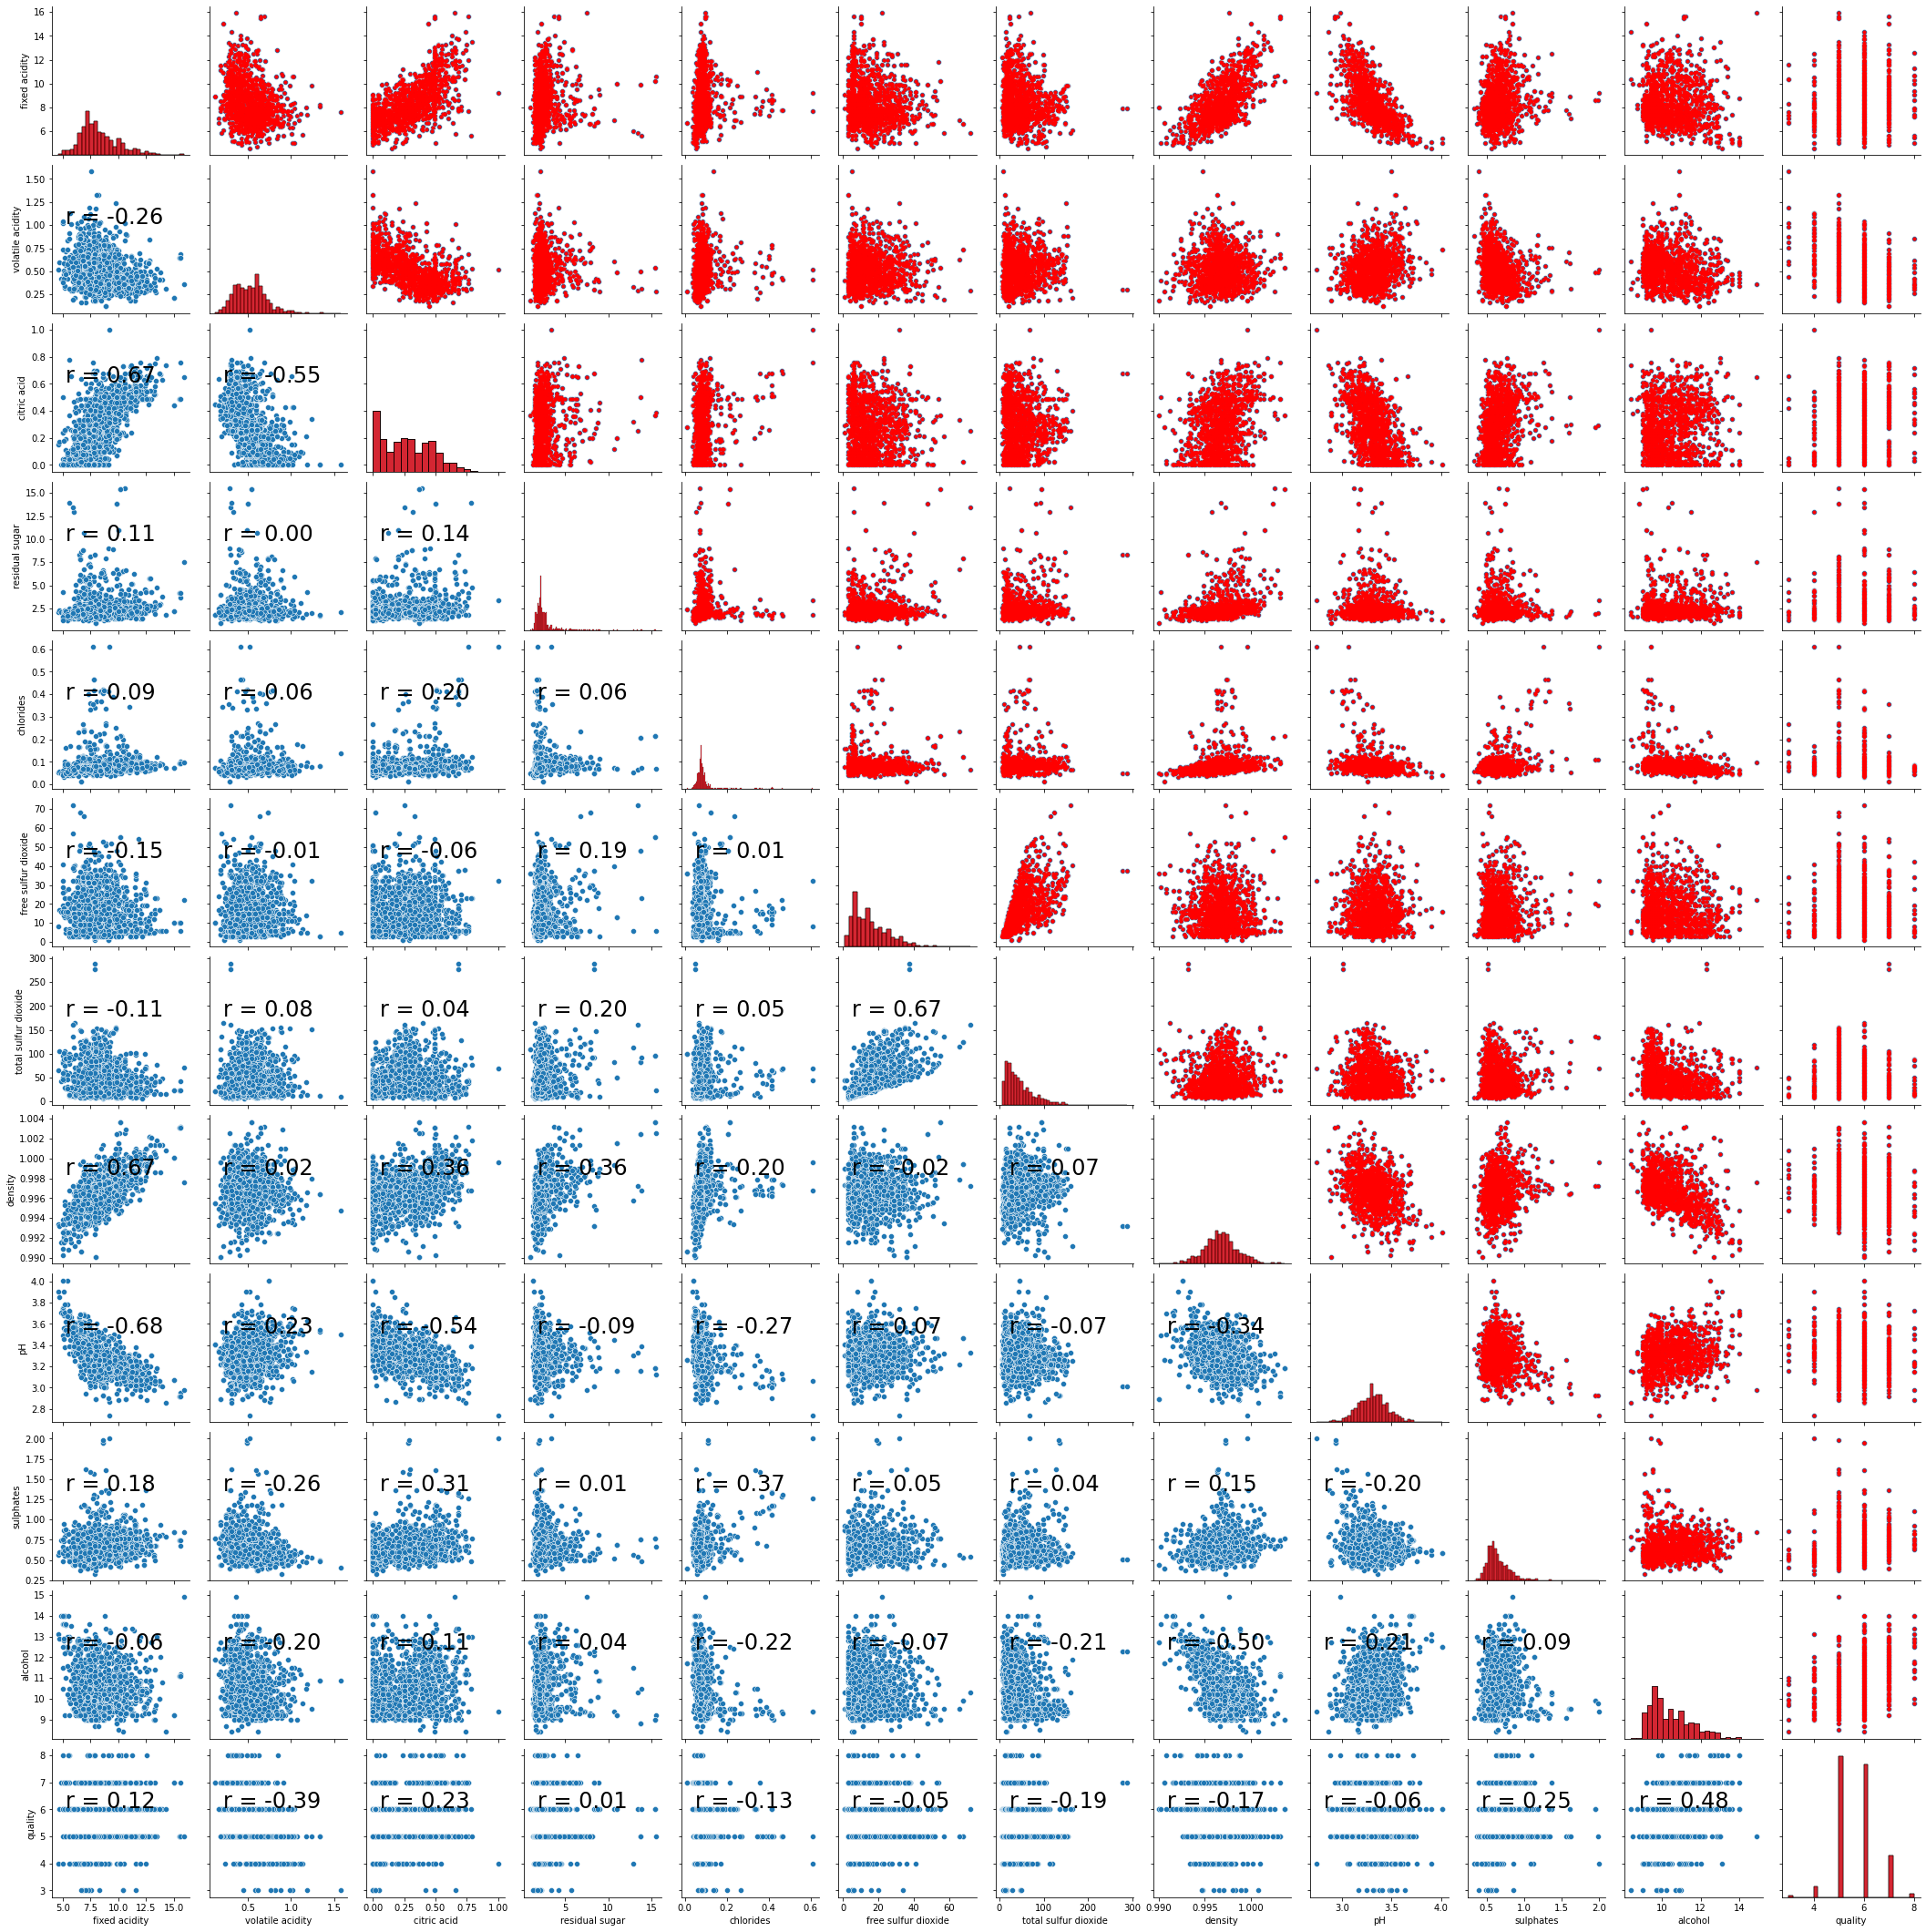

In [12]:
# Find correlation between features
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair plot
g = sns.pairplot(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
#g.map_diag(sns.distplot, kde=False, color = 'red') # distplot is deprecated
#g.map_diag(sns.displot, kde=False, color = 'red')
g.map_diag(sns.histplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
#g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

# Create a Separate Feature Set (Data Matrix X) and Target (1D Vector y)

Create a data matrix (X) that contains all features and a 1D target vector (y) containing the target.



In [28]:
# From correlation analysis, features don't seem all that redundant
# Also, it's a small dataset, so we will use all the features
# Multiclass classification will not one-hot encode the quality column
X = df.drop('quality',axis=1)
y = df['quality']

# Create Train and Test Dataset

Use the **"random_state"** attribute of the "train_test_split" function to ensure the reproducability of your results.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# <font color=blue>Polynomial Regression Using the OLS Method</font>



## Choose the Optimal Degree (Model Complexity) of the Polynomial Regression

Vary the degree of the polynomial (degree 1, 2, 3, 4, 5) and train the sklearn's Linear Regression model (OLS) using the training data. Then, compute the mean squared error (mse) for the test data using the models with varying degree.

Finally, plot the **root mean square error (rmse)** values against the varying degree. From this plot find the optimal degree (that gives the smallest rmse).


Use the "Computation of the Validation RMSE: Approach 1" & "Computation of the Validation RMSE: Approach 2" from the folllowing notebook.
https://github.com/rhasanbd/Linear-Regression-Extensive-Adventure/blob/master/Linear%20Regression-2-OLS%20Polynomial%20Regression-Frequentist%20Approach.ipynb


## Model's Complexity: Overfitting or Underfitting
If a model performs well on the training data but generalizes poorly (on the validation data) according to the cross-validation metrics, then your model is overfitting. If it performs poorly on both, then it is underfitting. This is one way to tell when a model is too simple or too complex.

## Computation of the Validation RMSE
We compute the validation RMSE using the following two approaches:

- Approach 1: when we have a large dataset for training, we set aside a fixed validation dataset for computing its RMSE.

- Approach 2: whe the available training dataset is small, we use cross-validation for computing the validation RMSE.

## Computation of the Validation RMSE: Approach 1

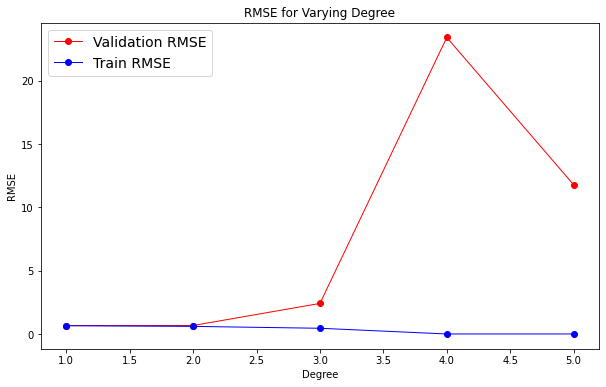

Optimal Degree:  1


In [35]:
# Partition the training data into train and validation subsets for this experiment
X_train_new, X_validation, y_train_new, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


degreeList = [1,2,3,4,5]

# Two lists to store train and validation MSE values for various models of varying complexity
mse_train_list, mse_validation_list = [], []

for degree in degreeList:

    # Create a pipeline object: first add polynomials, then standardize, finally create Linear Regression model 
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), LinearRegression()) 
  
    # Train the model
    model.fit(X_train_new, y_train_new)
       
    # Make prediction 
    y_train_predicted = model.predict(X_train_new)
    y_validation_predicted = model.predict(X_validation)
    
    
    # Compute MSE and add to the list
    mse_train_list.append(mean_squared_error(y_train_new, y_train_predicted))
    mse_validation_list.append(mean_squared_error(y_validation, y_validation_predicted))
    

# Plot RMSE values for varying polynomial degree
plt.figure(figsize=(10, 6))   
plt.plot(degreeList, np.sqrt(mse_validation_list), "ro-", alpha=1.0, linewidth=1.0, label="Validation RMSE")
plt.plot(degreeList, np.sqrt(mse_train_list), "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE")    
plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Degree")
plt.show()

# Find the value of optimal degree for the polynomial that gives smallest validation RMSE
rmse_validation = np.sqrt(mse_validation_list)
j = 0
min_rmse = rmse_validation[j]
optimal_degree = 1

for i in degreeList:
    if(rmse_validation[j] < min_rmse):
        min_rmse = rmse_validation[j]
        optimal_degree = i
    j +=1
print('Optimal Degree: ', optimal_degree)

## Computation of the Validation RMSE: Approach 2

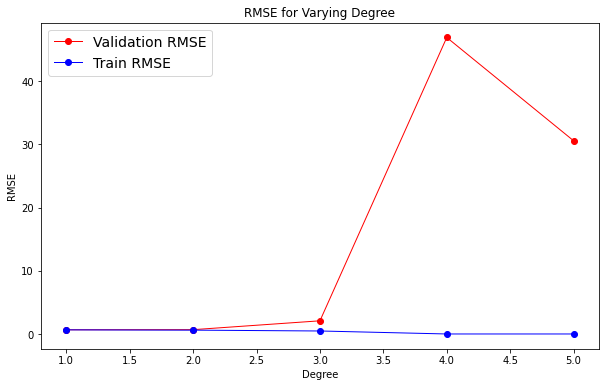

Optimal Degree:  1


In [34]:
degreeList = [1,2,3,4,5]

# Create two lists for storing MSE values (train & validation) for various polynomial degree values
mse_train_list, mse_validation_list = [], []

for degree in degreeList:

    # Create a OLS Linear Regression model using a pipeline object
    # In the pipeline, first add the polynomial features based on the given degree
    # Then, stadardize the data
    # Finally, create the Linear Regression model
    model = make_pipeline(PolynomialFeatures(degree, include_bias=False), StandardScaler(), LinearRegression()) 
  
    # Train the model
    model.fit(X_train, y_train)

    # Make prediction using the training data 
    y_train_predicted = model.predict(X_train)

    # Compute the training MSE 
    mse_train = mean_squared_error(y_train, y_train_predicted)
    # Compute the validation MSE 
    #  - Use sklearn's metrics.cross_val_score() function that employs the cross-validation technique
    # Set its scoring argument with the value "neg_mean_squared_error" 
    # It returns a list of the negative MSE values
    # The length of the list depends on the value of the function's "cv" argument
    # Compute the mean of the negative MSE values
    # Then, multiply the mean with "-" to get the validation MSE score
    validation_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

    # Compute the mean of the multiple validation score values
    mse_validation = -validation_scores.mean()

    
    mse_train_list.append(mse_train)
    mse_validation_list.append(mse_validation)
   

plt.figure(figsize=(10, 6))   
plt.plot(degreeList, np.sqrt(mse_validation_list), "ro-", alpha=1.0, linewidth=1.0, label="Validation RMSE")
plt.plot(degreeList, np.sqrt(mse_train_list), "bo-", alpha=1.0, linewidth=1.0, label="Train RMSE")  

plt.legend(loc="best", fontsize=14) 
plt.xlabel("Degree")
plt.ylabel("RMSE")
plt.title("RMSE for Varying Degree")
plt.show()

# Find the value the polynomial degree that gives the smallest validation RMSE
j = 0
min_validation_mse = mse_validation_list[j]
optimal_degree = 1

for i in degreeList:
    if(mse_validation_list[j] < min_validation_mse):
        min_validation_mse = mse_validation_list[j]
        optimal_degree = i
    j +=1
    
print("Optimal Degree: ", optimal_degree)

## Standardize the Features

In [30]:
from sklearn.preprocessing import scale
X_train=scale(X_train)
X_test=scale(X_test)

## Determine Model Complexity using Learning Curve

Determine your polynomial regression model's complexity (whether it's overfitting or underfitting) by creating learning curves by varying the degree of polynomial. 

Use sklearn's function for plotting the learning curves.


You will generate two set of learning curves.
- Linear Model
- 4th Degree Polynomial Model

Your goal is to investigate whether your two models are overfitting or underfitting. Under the "Observation" block clearly state your conclusion and justification.

## Learning Curve: Linear Model

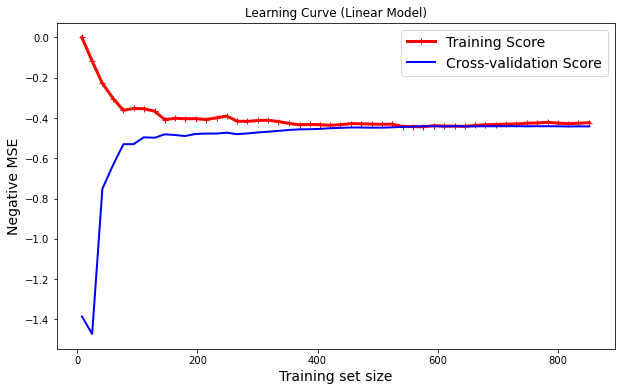

In [36]:
# Learning Curve: Linear Model
# Create CV training and validation scores for various training set sizes
train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), X_train, y_train, cv=3, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50),
                                                        n_jobs=-1)
                                                
                                                                                                                                                                                                                 
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve (Linear Model)")
plt.show()

## Observation: Linear Model Learning Curve

#### Conclusion:
The model is underfitting the data (high bias).

#### Justification:
The training error is low initially, when very few samples are used. However, the error increases rapidly when the training set size is increased because the linear model is not complex enough for the problem. The validation error begins extremely high because the linear model is incapable of generalizing with small data. The error decreases as more training samples are added but it reaches a plateau at a similar error as the training score. Since both the training and the validation errors reach a plateau and are fairly high, it's likely that the model is underfitting the data.

## Learning Curve: Polynomial Model (4th degree)

No. of Original Features:  11
No. of Augmented Features:  1364


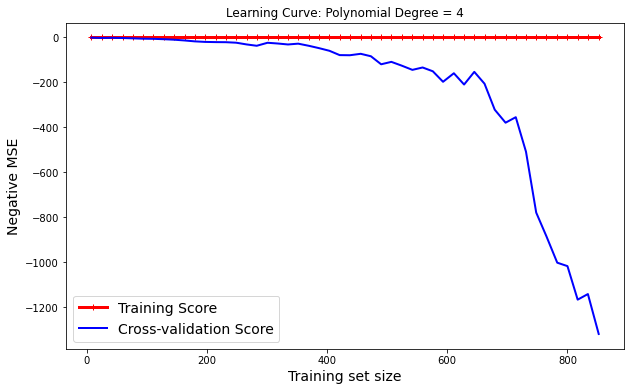

In [37]:
# Learning Curve: Polynomial (4th Degree) Model
# Variable that speficies the degree of the polynomial to be added to the feature vector
poly_degree = 4


# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

print("No. of Original Features: ", X_train.shape[1])
print("No. of Augmented Features: ", X_train_poly.shape[1])


scaler = StandardScaler().fit(X_train_poly)
X_train_poly_standardized = scaler.transform(X_train_poly)



train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), X_train_poly_standardized, y_train, cv=3, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
                                                                                                                                                                                                       
                                                        
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve: Polynomial Degree = %d" % poly_degree)
plt.show()


## Observation: Polynomial Model (4th degree) Learning Curve

##### Conclusion:
The model is overfitting the data (high variance).


##### Justification:
The training error is low no matter what the training set size is. Basically, the model is always able to fit the training data to a low error. However, as the sample size is increased, the validation score drastically lowers. It is not able to generalize well from the training data to the validation data. This is typical behavior of an overfitting model.

# <font color=blue>Stochastic Gradient Descent (SGD)


Using the **optimal degree** (obtained from the RMSE vs Degree curve) perform Gradient Descent based linear regression by using sklearn's SGDRegressor. You should use **regularized** SGDRegressor.

First, you will select the best model via hyperparameter tuning. Use sklearn's GridSearchCV.

Find the best combination of the following hyperparameters. You may add other parameters in this list if you find it reasonable.

- alpha
- learning_rate ("constant", "optimal")
- eta0
- l1_ratio
- max_iter
- eta0

The GridSearchCV takes an argument to define the scoring metric (performance measure). 

See the list of possible scoring functions:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

For regression, you may use "neg_mean_squared_error" or "explained_variance" scoring function. 


In [ ]:
# Augment the feature space if needed based on the optimal degree


# Display the number of original features & the augmented features

## Hyperparameter Tuning for SGD Regressor

You should tune the following hyperparameters. I have suggested some values and range, but you free to explore. 

- alpha: 0.1, 0.01, 0.001
- learning_rate: "constant", "optimal", "invscaling"
- max_iter': 100, 400, 1000, 5000, 10000, 20000
- eta0: 0.01, 0.001
- loss: 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'

#### Report the best score (negative mean squared error) & optimal hyperparameter values.

In [45]:
%%time
# Augment the feature space if needed based on the optimal degree
warnings.filterwarnings('ignore')

# Create a Pipeline object
sgd_pipeline = Pipeline([
        # Bias should be excluded because by default SGDRegressor adds bias via the"fit_intercept" parameter
        ('poly', PolynomialFeatures(include_bias=False)), 
        ('scaler', StandardScaler()),
        ('sgd', SGDRegressor(penalty='elasticnet')),
    ])

# Create a dictionary object with hyperparameters as keys and lists of corresponding values
param_grid = {'poly__degree': [1, 2, 3, 4, 5],
              'sgd__alpha': [0.1, 0.01, 0.001, 0.0001], 
              'sgd__l1_ratio': [1, 0.7, 0.5, 0.2, 0],
              'sgd__max_iter':[500, 1000],
              'sgd__eta0': [0.01, 0.001, 0.0001],
              'sgd__learning_rate': ['constant','optimal']}

# Create a GridSearchCV object and perform hyperparameter tuning
# We'll use negative MSE for the scoring and also set CV to 5
sgd = GridSearchCV(sgd_pipeline, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# The model is trained with optimal hyperparameters, thus its the optimal model
sgd.fit(X_train, y_train)

# Get the optimal hyperparameters
params_optimal_sgd = sgd.best_params_

print("Best Score (negative mean squared error): %f" % sgd.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sgd)
print("\n")


# Display the number of original features & the augmented features

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Best Score (negative mean squared error): -0.431809
Optimal Hyperparameter Values:  {'poly__degree': 2, 'sgd__alpha': 0.01, 'sgd__eta0': 0.001, 'sgd__l1_ratio': 1, 'sgd__learning_rate': 'constant', 'sgd__max_iter': 500}


Wall time: 15min 16s


## Select The Best Model for the SGD Regressor

Using the optimal hyperparameter values, create the best model.
Then, fit the model.


Report the following two evaluation metrics.

- Mean Squared Error (MSE)
- Coefficient of Determination or $R^2$ or $r^2$


In [54]:
# SGD Regression using the best model
# Training data: Make prediction 
y_train_predicted_sgd = sgd.predict(X_train)

print("Training Evaluation:")
print("\nMean squared error: %.2f"
      % mean_squared_error(y_train, y_train_predicted_sgd))

# Training data: Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_train, y_train_predicted_sgd))


Training Evaluation:

Mean squared error: 0.39
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.41


## Evaluate Model Performance Using Test Data

In [53]:
# Make prediction on the test data
y_test_predicted = sgd.predict(X_test)


print("Test Evaluation:")
print("\nMean squared error: %.2f"
      % mean_squared_error(y_test, y_test_predicted))


# Explained variance score: 1 is perfect prediction
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" 
      % r2_score(y_test, y_test_predicted))

Test Evaluation:

Mean squared error: 0.39
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.32
